In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from pytorchtools_CNN_paper import EarlyStopping

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

import scipy.stats as st

from matplotlib.offsetbox import AnchoredText

In [2]:
#GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
class CNN(nn.Module):

    def __init__(self, input_size, kernel_size, p, neg_slope):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
        
        nn.Conv2d(input_size, 32, kernel_size = 5, dtype = torch.double),# padding = 'same'),
        nn.ReLU(),
        # nn.Dropout2d(p = p),
        nn.MaxPool2d(2),
        # nn.BatchNorm2d(32, dtype = torch.double),

        nn.Conv2d(32, 32, kernel_size = 5, dtype = torch.double),# padding = 'same'),
        nn.ReLU(),
        # nn.Dropout2d(p = p),
        # nn.MaxPool2d(5, stride = 1),
        # nn.BatchNorm2d(32, dtype = torch.double),
        
        nn.Conv2d(32, 64, kernel_size = 2, dtype = torch.double),# padding = 'same'),
        nn.ReLU(),
        # nn.Dropout2d(p = p),
        nn.MaxPool2d(2),# stride = 1),
        # nn.BatchNorm2d(64, dtype = torch.double),
        
        )

        self.fcff = nn.Sequential(
        
        nn.Linear(576, 1000, dtype = torch.double),
        nn.Dropout1d(p = p),
        nn.BatchNorm1d(1000, dtype = torch.double),
        nn.LeakyReLU(neg_slope),

        nn.Linear(1000, 400, dtype = torch.double),
        nn.Dropout1d(p = p),
        nn.BatchNorm1d(400, dtype = torch.double),
        nn.LeakyReLU(neg_slope),

        nn.Linear(400, 200, dtype = torch.double),
        nn.Dropout1d(p = p),
        nn.BatchNorm1d(200, dtype = torch.double),
        nn.LeakyReLU(neg_slope),
        
        nn.Linear(200, 2, dtype = torch.double),

        )
        
        #self._init_weights(self.conv)
        #self._init_weights(self.fcff)
        self.apply(self._init_weights)
    
    def _init_weights(self,module):
        
        if isinstance(module, nn.Conv2d):
            torch.nn.init.dirac_(module.weight)
            if module.bias is not None:
                module.bias.data.fill_(0.08)
                
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.1)
            if module.bias is not None:
                module.bias.data.fill_(0.08)

        
    def forward(self, x1, x2):

        x1 = self.conv(x1)
        x1 = torch.flatten(x1, 1)
        x1 = self.fcff(x1)
        
        x2 = self.conv(x2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fcff(x2)
        
        return torch.stack([x1, x2])



In [4]:
class MyLoss (nn.Sequential):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, W, E):
        
        xw, yw = torch.nonzero(W, as_tuple = True)
        
        W = W[xw,yw]
        E = E[xw,yw]

        loss = torch.mean(torch.abs(E-W)/W).to(device)

        return loss

In [5]:
def Reg_Loss(loss, LAMBDA):
    
    l2_reg = 0
    for W in model.parameters():
        l2_reg = l2_reg + torch.norm(W, 1)
    
    loss_reg = loss + LAMBDA*l2_reg
    
    return loss_reg

In [6]:
def Dist(W, E):
    
    x, y = torch.nonzero(W, as_tuple = True)
    
    W = W[x,y]
    E = E[x,y]
    
    dist = E/W
    
    return dist

Validation loss decreased (inf --> 4.339756).  Saving model ...
Validation loss decreased (4.339756 --> 3.766675).  Saving model ...
Validation loss decreased (3.766675 --> 3.699717).  Saving model ...
Validation loss decreased (3.699717 --> 3.510360).  Saving model ...
Validation loss decreased (3.510360 --> 3.309574).  Saving model ...
Validation loss decreased (3.309574 --> 3.220699).  Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (3.220699 --> 3.059397).  Saving model ...
Validation loss decreased (3.059397 --> 2.971480).  Saving model ...
Validation loss decreased (2.971480 --> 2.868832).  Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (2.868832 --> 2.789109).  Saving model ...
Validation loss decreased (2.789109 --> 2.696837).  Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (2.696837 --> 2.490153).  Saving model ...
Validation loss decreased (2.490153 --> 2.457002).  Saving model ...
Ear

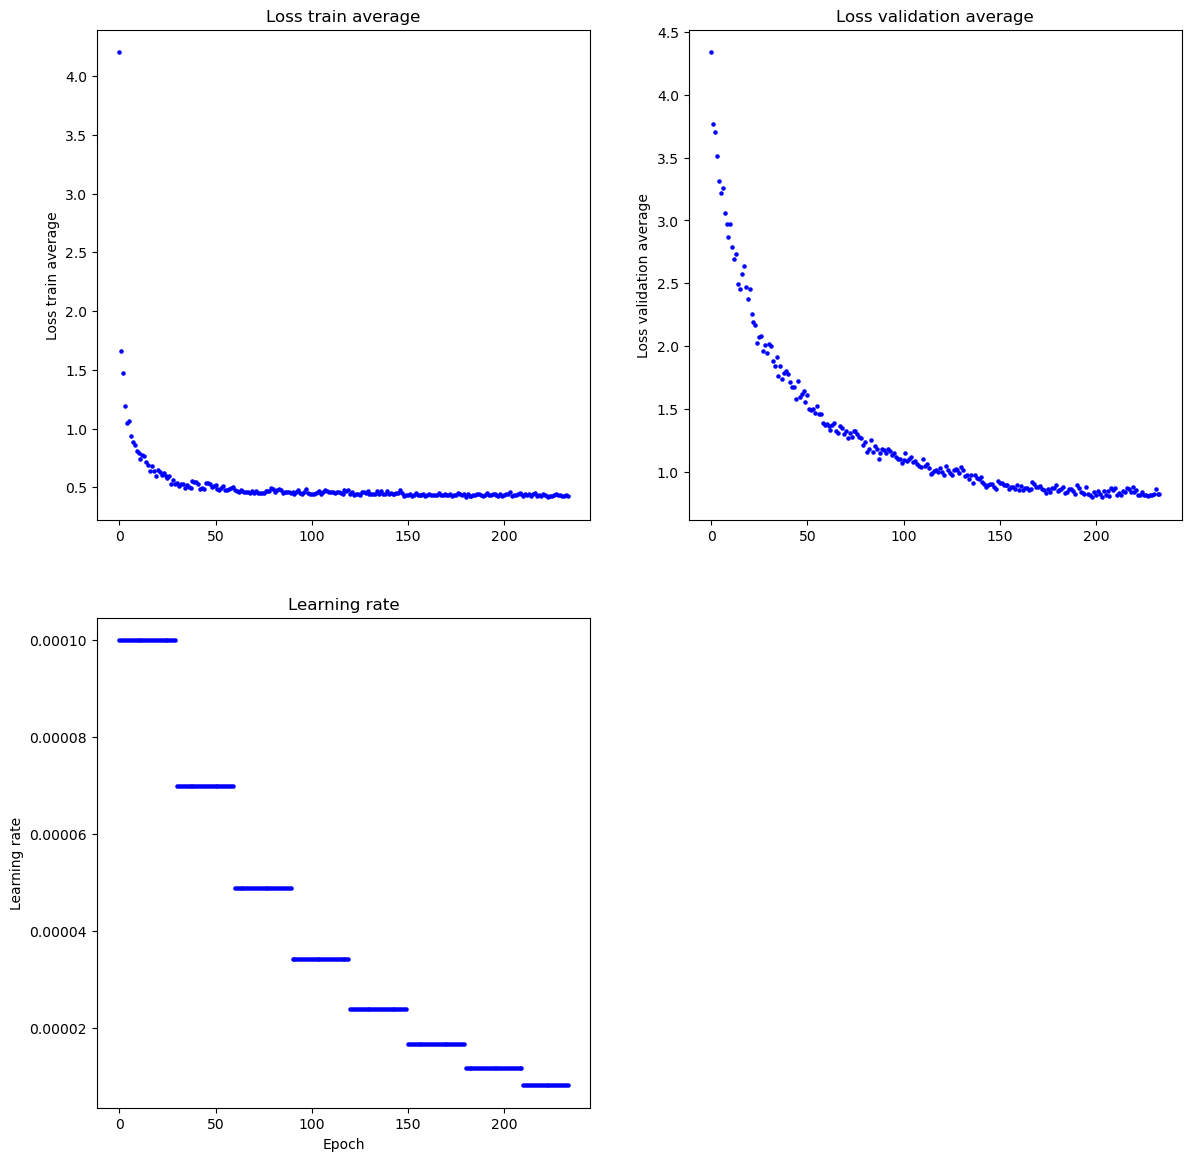

In [72]:
#Dataloder

train, targets_train, validation, targets_validation = torch.load('/home/gbortolai/Thesis/data/MNIST/train_validation_s=3000', map_location=device)
train = train.double()

W_dist_train, W_dist_validation = torch.load('/home/gbortolai/Thesis/data/MNIST/Wasserstein_dist_train_validation_s=3000', map_location=device)

validation = validation.view(W_dist_validation.size(0), 1, validation.size(1), validation.size(2)).double()

#parameters

n_sample_train = train.size(0)
n_sample_validation = validation.size(0)

batch_size = 300

n_batches_train = int(n_sample_train/batch_size)
n_batches_validation = int(n_sample_validation/batch_size)

train = torch.stack(torch.chunk(train, n_batches_train, dim = 0), dim = 0).view(n_batches_train, batch_size, 1, 28, 28)
W_dist_train = torch.stack(torch.chunk(torch.stack(torch.chunk(W_dist_train, n_batches_train, dim = -1), dim = 0), n_batches_train, dim = 1), dim = 0)


input_size = 1
kernel_size = 5

#Train
#-----------------------------------------------------------------------------------------------------------SETTING
learning_rate = 1e-4

criterion = MyLoss()
#criterion = nn.MSELoss()

LAMBDA = 0


patience = 30

iteration = 1000

counter_train = 0 
counter_validation = 0

neg_slope = 1e-2

p = 0.4

model = CNN(input_size, kernel_size, p, neg_slope).to(device)

optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay = 0)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.7)


fig = plt.figure(figsize = (14, 14), constrained_layout=False)
gs = GridSpec(2, 2, figure = fig)

ax3 = fig.add_subplot(gs[0, 0])
ax3.set_title('Loss train average')
ax3.set_ylabel('Loss train average')
ax3.set_ybound(lower = 0, upper = None)

ax4 = fig.add_subplot(gs[0, 1])
ax4.set_title('Loss validation average')
ax4.set_ylabel('Loss validation average')
ax4.set_ybound(lower = 0, upper = None)

ax5 = fig.add_subplot(gs[1, 0])
ax5.set_title('Learning rate')
ax5.set_ylabel('Learning rate')
ax5.set_xlabel('Epoch')

train_losses = []


early_stopping = EarlyStopping(patience = patience, verbose = True)

#---------------------------------------------------------------------------------NN
for ite in range (iteration):
    #Train
    #---------------------------------------------------------------------------TRAIN
    model.train()
    for batch_x in range (n_batches_train):
        for batch_y in range (n_batches_train):
            if torch.count_nonzero(W_dist_train[batch_x][batch_y]) == 0:continue
            else:
                #embedding
                sample_emb_train = model(train[batch_x], train[batch_y]).to(device)

                E_dist_train = torch.cdist(sample_emb_train[0], sample_emb_train[1], p = 2).to(device) 

                loss = criterion(W_dist_train[batch_x][batch_y], E_dist_train)
                dist = Dist(W_dist_train[batch_x][batch_y], E_dist_train)
                loss_reg = Reg_Loss(loss, LAMBDA)
                counter_train = counter_train + 1
                train_losses.append(loss_reg.item())

                optimizer.zero_grad()
                loss_reg.requires_grad_()
                loss_reg.backward(retain_graph=True)

                optimizer.step()
#----------------------------------------------------------------------------------------------------------------------VALIDATION
    train_loss = np.average(train_losses)
    ax3.scatter(ite,train_loss,color='b', s=5)
    
    #Validation
    model.eval()
    #embedding
    sample_emb_validation = model(validation, validation).to(device)

    E_dist_validation = torch.cdist(sample_emb_validation[0], sample_emb_validation[0], p = 2).to(device)

    valid_loss = criterion(W_dist_validation, E_dist_validation)
    valid_dist = Dist(W_dist_validation, E_dist_validation)
    # valid_loss_reg = Reg_Loss(valid_loss, LAMBDA)

    counter_validation = counter_validation + 1

#------------------------------------------------------------------------------------------PLOT
    ax4.scatter(ite, valid_loss.cpu().detach().numpy(),color='b', s=5)
    ax5.scatter(ite, optimizer.param_groups[0]['lr'], color = 'b', s = 5)

    train_losses = []
    valid_losses = []

    early_stopping(valid_loss, model)
    scheduler.step()


    if early_stopping.early_stop:
            print("Early stopping")
            break


In [73]:
test, targets_test = torch.load('/home/gbortolai/Thesis/data/MNIST/test_s=1500', map_location=device)
W_dist_test, target_test = torch.load('/home/gbortolai/Thesis/data/MNIST/Wasserstein_dist_test_s=1500', map_location=device)

test = test.view(W_dist_test.size(0), 1, test.size(1), test.size(2))
W_dist_test = torch.triu(W_dist_test).double()


criterion = MyLoss()
#criterion = nn.MSELoss()

# LAMBDA = 1e-6

neg_slope = 1e-2

p = 0.1

input_size = 1
kernel_size = 5

model = CNN(input_size, kernel_size, p, neg_slope).to(device)


#test 
model.load_state_dict(torch.load('/home/gbortolai/Thesis/Checkpoint/checkpoint_CNN-paper.pth', map_location = device))
#-----------------------------------------------------------------------------------SETTING
model.eval()
#--------------------------------------------------------------------------------------EMBEDDING

sample_emb_test = model(test, test).to(device)

E_dist_test = torch.cdist(sample_emb_test[0], sample_emb_test[1], p = 2).to(device)

test_loss = criterion(W_dist_test, E_dist_test)
test_dist = Dist(W_dist_test, E_dist_test)
# test_loss_reg = Reg_Loss(test_loss, LAMBDA)

test_dist_mean = torch.mean(test_dist)
var_test = np.sqrt(torch.mean((1-test_dist_mean)*(1-test_dist_mean)).cpu().detach().numpy())

median_test = torch.median(test_dist)

print('Dist mean:', test_dist_mean.item(),u"\u00B1", var_test.item())

Dist mean: 1.6837023371293567 ± 0.6837023371293567


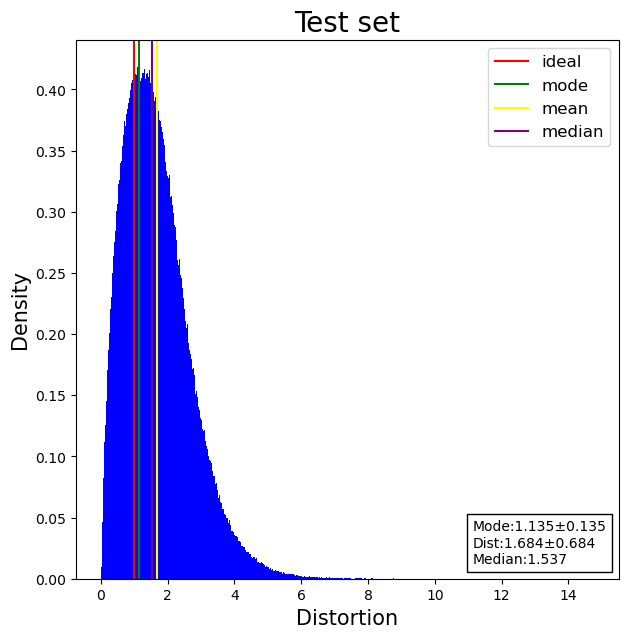

In [74]:
fig3, ax3_test = plt.subplots(1,1, figsize=(7,7))

ax3_test.set_title('Test set', fontsize = 20)

# ax3_test.set_xlim([-0.1,2])
ax3_test.set_xlabel("Distortion", fontsize = 15)
ax3_test.set_ylabel("Density", fontsize = 15)
labels = ['ideal', 'mode', 'mean','median']
#plt.axhline(y=1, color='r', linestyle='-')
#for i in range(targets_test.size(0)):
    #if targets_test[i] == 2:
count_test, bins_test, p_test = ax3_test.hist(test_dist.cpu().detach().numpy(), color = 'b', bins = 840, density = True)
ax3_test.axvline(x=1, color='r', linestyle='-')

mode_index_test = count_test.argmax()
mode_test = (bins_test[mode_index_test] + bins_test[mode_index_test+1])/2
var_mode_test = np.sqrt(np.average((1-mode_test)*(1-mode_test)))

ax3_test.axvline(x=mode_test, color='green', linestyle='-')
ax3_test.axvline(x=test_dist_mean.cpu().detach().numpy(), color='yellow', linestyle='-')
ax3_test.axvline(x=median_test.cpu().detach().numpy(), color='purple', linestyle='-')
#plt.axvline(x=test_loss.detach().numpy(), color='orange', linestyle='-')
ax3_test.legend(labels, fontsize = 12)

anchored_text_test = AnchoredText('Mode:'+str('%.3f' % mode_test.item())+u"\u00B1"+str('%.3f' % var_mode_test.item())+'\nDist:'+str('%.3f' % test_dist_mean.item())+u"\u00B1"+str('%.3f' % var_test.item()+'\nMedian:'+str('%.3f' % median_test.item())), loc='lower right')
ax3_test.add_artist(anchored_text_test)


In [79]:
fig3.savefig('/home/gbortolai/Thesis/Plot/MNIST/CNN-paper_myloss-channels_uguale.pdf', facecolor='w',pad_inches=0.3, transparent=True)

In [ ]:
#------------------------------------------------------------------------------------PLOT
labels = ['0','1','2','3','4','5','6','7','8','9']

colors = ['b', 'g', 'r','c','m','y','k', 'teal', 'purple', 'lime' ]

var, col = [], []

n_bullet = 0
n_target = 0

for n_bullet in [0,1,2,3,4,5,6,7,8,9]:
    for n_target in [0,1,2,3,4,5,6,7,8,9]:
        if n_target > n_bullet:
            fig_test = plt.figure(figsize=(14, 7), constrained_layout=False)
            gs_test = GridSpec(1, 2, figure = fig_test)

            fig_test.suptitle('MNIST')

            ax1_test = fig_test.add_subplot(gs_test[0, 1])
            ax1_test.set_title('Kernel density estimation')
            ax1_test.set_xlabel('Embedded x')
            ax1_test.set_ylabel('Embedded y')

            ax2_test = fig_test.add_subplot(gs_test[0,0])
            ax2_test.set_title('Embedded space')
            ax2_test.set_xlabel('Embedded x')
            ax2_test.set_ylabel('Embeddded y')

            for j in [n_bullet,n_target]:
                for i in range (sample_emb_test.size(0)):
                    if targets_test[i] == j:
                        ax2_test.scatter(sample_emb_test[i][0].cpu().detach().numpy(), sample_emb_test[i][1].cpu().detach().numpy(), color = colors[j], s=10, alpha = 0.5)
                var.append(labels[j])
                col.append(colors[j])

            ax2_test.legend(var,loc = 'best', fontsize = 12)

            leg = ax2_test.get_legend()    
            for i in range(len(var)):

                leg.legend_handles[i].set_color(col[i])
            #------------------------------------------------------KDE
            #fig, ax = plt.subplots()

            h = []

            for k in [n_bullet,n_target]:
                ind = torch.count_nonzero(targets_test == k)
                X = torch.zeros(1,1).expand(ind, 2).clone()

                l=0
                for i in range (sample_emb_test.size(0)):
                    if targets_test[i] == k:

                        X[l] = sample_emb_test[i]
                        l = l+1


                # Extract x and y
                x = X[:, 0]
                y = X[:, 1]

                # Define the borders
                deltaX = (torch.max(x) - torch.min(x))/5
                deltaY = (torch.max(y) - torch.min(y))/5
                xmin = torch.min(x).item() - deltaX.item()
                xmax = torch.max(x).item() + deltaX.item()
                ymin = torch.min(y).item() - deltaY.item()
                ymax = torch.max(y).item() + deltaX.item()

                # Create meshgrid
                xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

                x = x.detach().numpy()
                y = y.detach().numpy()

                positions = np.vstack([xx.ravel(), yy.ravel()])
                values = np.vstack([x, y])

                kernel = st.gaussian_kde(values)
                kernel.set_bandwidth(bw_method=0.5)

                f = np.reshape(kernel(positions).T, xx.shape)


                #ax1_test = plt.gca()
                cset = ax1_test.contour(xx, yy, f, levels = [80], colors=colors[k])
                h1, l1 = cset.legend_elements()
                h.append(h1[0])

            ax1_test.legend(h, var, loc = 'best', fontsize = 12)
            var, col, h = [], [], [] 
            # fig_test.savefig('/home/gbortolai/Thesis/Plot/MNIST/Emb/CNN-paper/MyLoss/KDE'+str([n_bullet,n_target])+'.pdf', facecolor='w',pad_inches=0.3, transparent=True)
plt.show()

In [ ]:
torch.save([sample_emb_test, targets_test],'/home/gbortolai/Thesis/data/MNIST/sample_emb_test_s='+str(test.size(0)))

In [ ]:
fig_test.savefig('/home/gbortolai/Thesis/Plot/MNIST/Embedding.pdf', facecolor='w',pad_inches=0.3, transparent=True)

In [12]:
#plotting E_dist emb

E = torch.cdist(sample_emb_test[0], sample_emb_test[0], p = 2)
torch.save([E, targets_test],'/home/gbortolai/Thesis/data/MNIST/E_dist_CNN-paper_s='+str(test.size(0)))

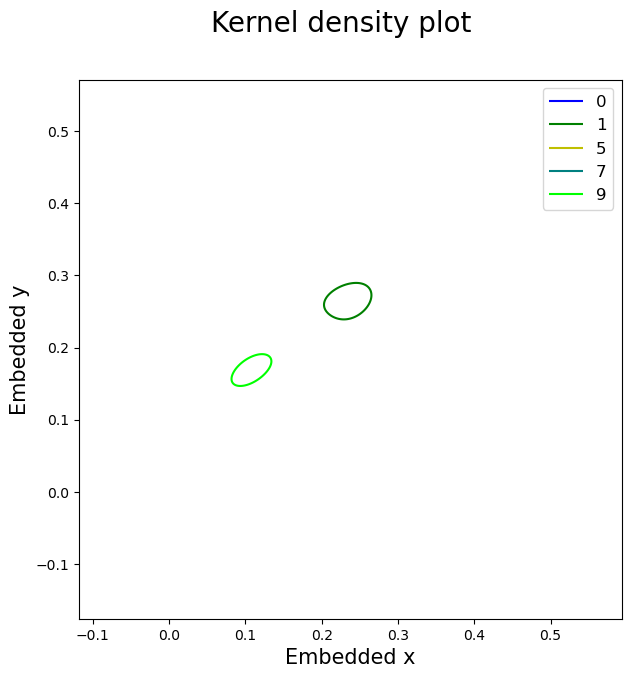

In [78]:
labels = ['0','1','2','3','4','5','6','7','8','9']

colors = ['b', 'g', 'r','c','m','y','k', 'teal', 'purple', 'lime' ]

fig, ax = plt.subplots(1,1, figsize = (7,7))
fig.suptitle('Kernel density plot', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

lab, h = [], []

for k in [0,1,5,7,9]:
    ind = torch.count_nonzero(targets_test == k)
    X = torch.zeros(1,1).expand(ind, 2).clone()

    l=0
    for i in range (sample_emb_test[0].size(0)):
        if targets_test[i] == k:

            X[l] = sample_emb_test[0][i]
            l = l+1


    # Extract x and y
    x = X[:, 0]
    y = X[:, 1]

    # Define the borders
    deltaX = (torch.max(x) - torch.min(x))/5
    deltaY = (torch.max(y) - torch.min(y))/5
    xmin = torch.min(x).item() - deltaX.item()
    xmax = torch.max(x).item() + deltaX.item()
    ymin = torch.min(y).item() - deltaY.item()
    ymax = torch.max(y).item() + deltaX.item()

    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

    x = x.detach().numpy()
    y = y.detach().numpy()

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])

    kernel = st.gaussian_kde(values)
    kernel.set_bandwidth(bw_method=0.5)

    f = np.reshape(kernel(positions).T, xx.shape)


    #ax1_test = plt.gca()
    #print(colors[k])
    cset = ax.contour(xx, yy, f, levels = [80], colors = colors[k])

    h1, l1 = cset.legend_elements()
    h.append(h1[0])
    lab.append(labels[k])

ax.legend(h, lab, loc = 'best', fontsize = 12)
fig.savefig('/home/gbortolai/Thesis/Plot/MNIST/KDE_01579_myloss_CNN-paper-channel_uguale.pdf', facecolor='w',pad_inches=0.3, transparent=True)
lab, h = [], []

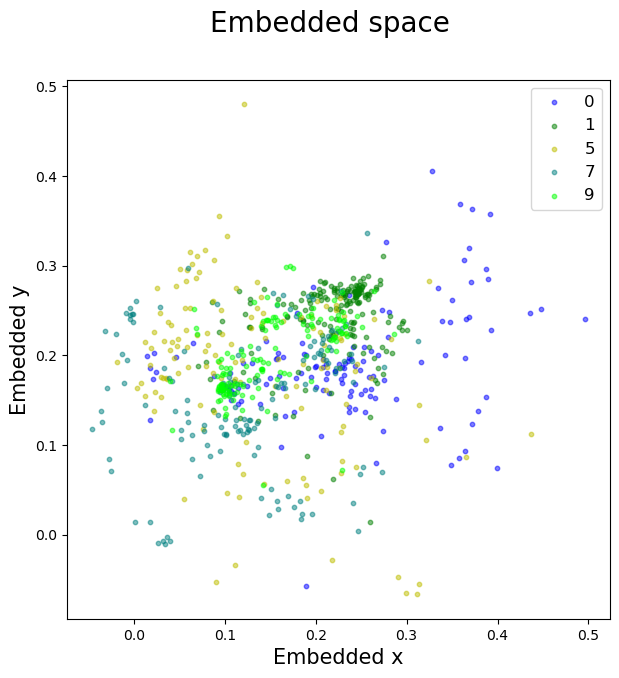

In [80]:
labels = ['0','1','2','3','4','5','6','7','8','9']

colors = ['b', 'g', 'r','c','m','y','k', 'teal', 'purple', 'lime' ]

var, col = [], []

fig, ax = plt.subplots(1,1, figsize = (7,7))
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (10,10))

fig.suptitle('Embedded space', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

for j in [0,1,5,7,9]:
    for i in range (sample_emb_test[0].size(0)):
                        if targets_test[i] == j:
                            ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j], s=10, alpha = 0.5)
                            # ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), sample_emb_test[0][i][2].cpu().detach().numpy(), color = colors[j], s=10, alpha = 0.5)
    var.append(labels[j])
    col.append(colors[j])
    
ax.legend(var,loc = 'best', fontsize = 12)

leg = ax.get_legend()    
for i in range(len(var)):

    leg.legend_handles[i].set_color(col[i])
    
fig.savefig('/home/gbortolai/Thesis/Plot/MNIST/Embedded_01579_myloss_CNN-paper_channel_uguale.pdf', facecolor='w',pad_inches=0.3, transparent=True)
var, col = [], []